In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing both the train and test dataset

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

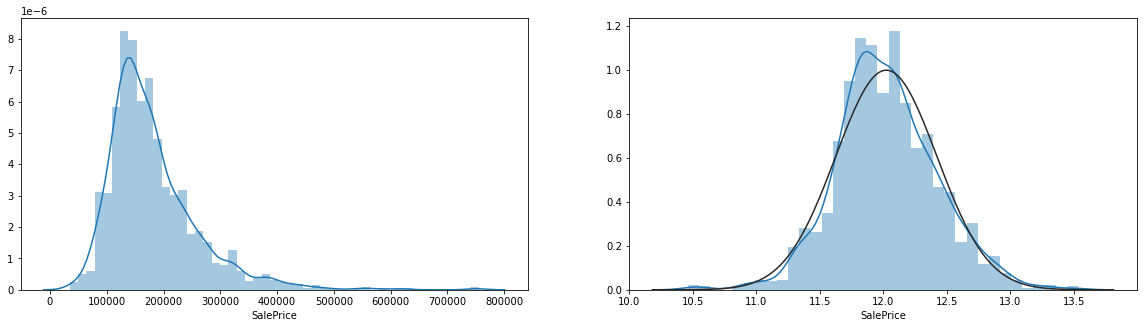

In [3]:
# Distribution Plot for SalePrice

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
sns.distplot(df_train.SalePrice, ax=ax1)
sns.distplot(np.log1p(df_train.SalePrice), fit=norm, ax=ax2)

In [4]:
# Log transforming the dependent variable, SalePrice
df_train.SalePrice = np.log1p(df_train.SalePrice)

# combining both the train and test dataset together for cleaning, feature engineering, and dimensional reduction
df_fullset = pd.concat([df_train, df_test], axis = 0)

# Extracting the train y values
y = df_train.SalePrice
y_full = df_fullset.SalePrice

# ID values from the test data
test_id = df_test.Id

# The variables in the dataset
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Dealing With Missing Data

In [5]:
# Create a dataframe that sums the number of missing values for each variable
missing = pd.DataFrame(df_fullset.isnull().sum()).rename(columns = {0:'number of nulls'}).sort_values('number of nulls', ascending = False)
missing[:20]

,number of nulls
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
SalePrice,1459
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageCond,159


In [6]:
# Drop the variables that have more than 4 missing observations
df_fullset.drop(missing[missing['number of nulls'] > 200].index, axis=1, inplace = True)

# dataset that that have more than 1 null but less than or equal to 4
missing = pd.DataFrame(df_fullset.isnull().sum()).rename(columns = {0:'number of nulls'}).sort_values('number of nulls', ascending = False)
missing = missing[(missing['number of nulls'] >= 1) & (missing['number of nulls'] <=4)]

# variables that have missing values and with an int or float datatype
num = df_fullset[missing.index].select_dtypes(include = ['int64', 'float64']).columns

# fill in the missing value with the median value for each variable
for item in num:
    df_fullset[item] = df_fullset[item].fillna(df_fullset[item].median())

# variables that have missing values and with an object datatype
category = df_fullset[missing.index].select_dtypes(include = ['object']).columns

# fill in the missing value with the mode value for each variable
for item in category:
     df_fullset[item] = df_fullset[item].fillna(df_fullset[item].mode()[0])

In [7]:
# Keep these missing values since it would be too difficult to handle with simple imputation
pd.DataFrame(df_fullset.isnull().sum()).rename(columns = {0:'number of nulls'}).sort_values('number of nulls', ascending = False)[:12]

,number of nulls
GarageYrBlt,159
GarageFinish,159
GarageQual,159
GarageCond,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81
BsmtFinType2,80
BsmtFinType1,79


# Adjusting for Skewness

In [8]:
# calculate the skew for int and float datatypes
skewed_features = df_fullset.select_dtypes(include = ['int64', 'float64']).apply( 
lambda x: skew(x)).sort_values(ascending = False)
skewed_features

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425378
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162616
BsmtUnfSF         0.919703
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.241184
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
Id                0.000000
GarageCars       -0.218593
YearRemodAdd     -0.451020
YearBuilt        -0.599806
MasVnrArea             NaN
GarageYrBlt            NaN
dtype: float64

In [9]:
# list of variables that have a skewness greater than 0.4
high_skew = skewed_features[abs(skewed_features) > 0.4]

# Log transform all variables that have skewness greather than 0.4
for item in high_skew.index:
    df_fullset[item] = np.log1p(df_fullset[item])

# Correlation Matrix

In [ ]:
df_fullset['TotalSF'] = df_fullset['TotalBsmtSF'] + df_fullset['1stFlrSF'] + df_fullset['2ndFlrSF']
df_fullset.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis = 1, inplace = True)
df_fullset.drop('Id', axis=1, inplace= True)

In [ ]:
# Correlation Matrix
# The Correlation Matrix will only calculate those with a numerical value
corr_df = pd.concat([df_fullset, y_full], axis=1)
corr = corr_df.corr()

# Plot the Correlation Matrix
plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap='coolwarm_r',center=0, linewidths=1)
plt.show()

In [ ]:
# Plot the correlation matrix with only variables that have a 0.3 (30%) or greather correlation coeffcient with SalePrice
plt.subplots(figsize=(10,10))
highest_features = corr.index[abs(corr["SalePrice"])>= 0.3]
sns.heatmap(corr_df[highest_features].corr(), cmap='coolwarm_r')
plt.show()

# list of variables that do not meet the 0.3 (30%) threshold
drop = corr.index[abs(corr["SalePrice"]) < 0.3]

# drop the variables
df_fullset.drop(drop, axis=1, inplace= True)

In [12]:
df_fullset1 = df_fullset
df_fullset1 = pd.get_dummies(df_fullset1)
df_fullset1.shape

(2919, 270)

In [13]:
X = df_fullset1[:len(y)]
X_test = df_fullset1[len(y):]

In [14]:
X_train, X1_test, y_train, y1_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# XGBoost Parameter Tunning

In [18]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, dtrain['SalePrice'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold = cv_folds,
                         metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        print(alg.set_params(n_estimators=cvresult.shape[0]))
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['SalePrice'], eval_metric='rmse')
    
    #Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    # dtest_predictions = alg.predict(X1_test[predictors])

    #Print model report:
    print("\nModel Report")
    print('Estimators: %.4g' %cvresult.shape[0])
    print("MSE (Train) : %.4g" % mean_squared_error(dtrain['SalePrice'].values, dtrain_predictions))
    # print("MSE (Test) : %.4g" % mean_squared_error(y1_test, dtest_predictions))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [19]:
# X1_test, y1_test
training_file = pd.concat([X, y], axis=1)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=226, n_jobs=None, nthread=4, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=1, seed=27, subsample=0.8, tree_method=None,
             validate_parameters=None, verbosity=None)

Model Report
Estimators: 226
MSE (Train) : 0.000841


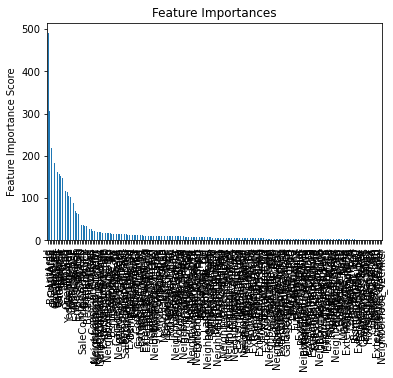

In [20]:
predictors = [x for x in training_file.columns if x not in ['SalePrice']]

xgb1 = XGBRegressor(learning_rate = 0.1,
                    n_estimators = 1000,
                    max_depth = 5,
                    min_child_weight = 1,
                    gamma = 0,
                    subsample = 0.8,
                    colsample_bytree = 0.8,
                    nthread = 4,
                    scale_pos_weight = 1,
                    seed = 27)

modelfit(xgb1, training_file, predictors)

In [21]:
param_test1 = {
    
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
    
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226, 
                                                 max_depth=5,min_child_weight=1, gamma=0, 
                                                 subsample=0.8, colsample_bytree=0.8,
                                                nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch1.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, -0.015669041129702226)

In [24]:
param_test2 = {
    'max_depth': [1,2,3,4,5],
    'min_child_weight': [1,2,3]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226, 
                                                 max_depth=5, min_child_weight=1, gamma=0, 
                                                 subsample=0.8, colsample_bytree=0.8,
                                                nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test2, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch2.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch2.best_params_, gsearch2.best_score_ >= gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 3}, True)

In [32]:
param_test2b = {
    'min_child_weight': [1,2,3,4,5,6,7,8]
}

gsearch2b = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226,
                                                 max_depth=4,min_child_weight=1, gamma=0, 
                                                 subsample=0.8, colsample_bytree=0.8,
                                                nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test2b, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch2b.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch2b.best_params_, gsearch2b.best_score_ >= gsearch2.best_score_

({'min_child_weight': 3}, True)

In [33]:
param_test3 = {
    'gamma' : [i/100.0 for i in range(0,6)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226,
                                                 max_depth=4,min_child_weight=3, gamma=0, 
                                                 subsample=0.8, colsample_bytree=0.8,
                                                nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test3, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch3.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch3.best_params_, gsearch3.best_score_ >= gsearch2b.best_score_

({'gamma': 0.0}, True)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=226, n_jobs=None, nthread=4, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=1, seed=27, subsample=0.8, tree_method=None,
             validate_parameters=None, verbosity=None)

Model Report
Estimators: 226
MSE (Train) : 0.002209


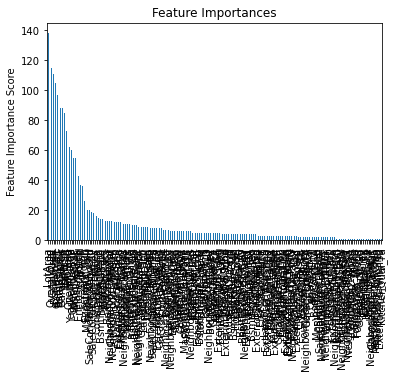

In [35]:
xgb2 = XGBRegressor(learning_rate = 0.1,
                    n_estimators = 226,
                    max_depth = 4,
                    min_child_weight = 3,
                    gamma = 0,
                    subsample = 0.8,
                    colsample_bytree = 0.8,
                    nthread = 4,
                    scale_pos_weight = 1,
                    seed = 27)

modelfit(xgb2, training_file, predictors)

In [38]:
param_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree' : [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226,
                                                 max_depth=4,min_child_weight=3, gamma=0, 
                                                 subsample=0.8, colsample_bytree=0.8,
                                                nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test4, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch4.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch4.best_params_, gsearch4.best_score_ >= gsearch3.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.8}, True)

In [40]:
param_test5 = {
    'subsample' : [i/100.0 for i in range(75,85,1)],
    'colsample_bytree' : [i/100.0 for i in range(55,65,1)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226,
                                                 max_depth=4,min_child_weight=3, gamma=0, 
                                                 subsample=0.8, colsample_bytree=0.8,
                                                nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test5, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch5.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch5.best_params_, gsearch5.best_score_ >= gsearch4.best_score_

({'colsample_bytree': 0.61, 'subsample': 0.83}, True)

In [45]:
param_test6 = {
    'reg_alpha' : [0.00001, 0.0001, 0.001, 0]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=226,
                                                 max_depth=4,min_child_weight=3, gamma=0, 
                                                 subsample=0.83, colsample_bytree=0.61,
                                                nthread=4, scale_pos_weight=1, seed=27),
                       param_grid = param_test6, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch6.fit(training_file[predictors], training_file['SalePrice'])

# gsearch.cv_results_
gsearch6.best_params_, gsearch6.best_score_ >= gsearch5.best_score_

({'reg_alpha': 0}, True)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.61, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.169, max_delta_step=None, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=226, n_jobs=None, nthread=4, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=1, seed=27, subsample=0.83, tree_method=None,
             validate_parameters=None, verbosity=None)

Model Report
Estimators: 226
MSE (Train) : 0.0009896


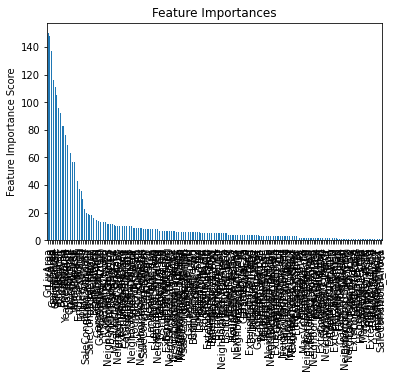

In [70]:
xgb3 = XGBRegressor(learning_rate = 0.169,
                    n_estimators = 226,
                    max_depth = 4,
                    min_child_weight = 3,
                    gamma = 0,
                    subsample = 0.83,
                    colsample_bytree = 0.61,
                    nthread = 4,
                    scale_pos_weight = 1,
                    seed = 27)

modelfit(xgb3, training_file, predictors)

# Submission

In [73]:
predictors = [x for x in X.columns if x not in ['SalePrice']]

xgb_model = XGBRegressor(learning_rate = 0.169,
                    n_estimators = 226,
                    max_depth = 4,
                    min_child_weight = 3,
                    gamma = 0,
                    subsample = 0.83,
                    colsample_bytree = 0.61,
                    nthread = 4,
                    scale_pos_weight = 1,
                    seed = 27)

xgb_fit = xgb_model.fit(X[predictors], y)
pred_y = np.floor(np.expm1(xgb_fit.predict(X_test[predictors])))
pred_y

array([118456., 157625., 189309., ..., 151758., 106895., 226311.],
      dtype=float32)

In [74]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = pred_y
submission.to_csv('submission.csv', index=False)